<center>
    <img src='images/tiny-uai.jpeg'style="width: 200px;">
</center>

# Laboratorio 04: ARIMA vs LSTM

## Deep Learning
   
<center>
    <img src='images/fourier.jpg'style="width: 400px;">
</center>

**Profesor**: Juan Bekios Calfa

**Carreras**: MIA

###### Basado en el tutorial: [ARIMA vs. LSTM: Forecasting Electricity Consumption (Michael Grogan)](https://towardsdatascience.com/arima-vs-lstm-forecasting-electricity-consumption-3215b086da77)


# Descripción del problema

* **Pronóstico del consumo de electricidad mediante ARIMA:** Este ejemplo utiliza el modelo ARIMA para pronosticar el consumo de electricidad utilizando datos de gov.ie. La serie temporal va del 29 de marzo de 2011 al 17 de febrero de 2013.

## Pronóstico del consumo de electricidad con Pytorch

El análisis tiene tres etapas: 

1. Revisar los  procedimientos de manipulación de datos relevantes para sumar el consumo total de kilovatios por día, es decir, formar una serie de tiempo diaria. 
2. Pronosticar el consumo de kilovatios en el conjunto de prueba utilizando un modelo ARIMA. 
3. Generar otro pronóstico en todo el conjunto de pruebas utilizando un modelo LSTM y examine si las predicciones mejoran.

# Base de datos

*  Base de datos  de consumo de electricidad de  _Dublin City Council Civic Offices, Ireland_.
*  Los datos se proporcionan en términos de consumo de kilovatios cada 15 minutos.
*  *Fuente:* https://data.gov.ie/dataset/energy-consumption-gas-and-electricity-civic-offices-2009-2012/resource/6091c604-8c94-4b44-ac52-c1694e83d746

# Método de trabajo

Una vez descargados los datos, debemos realizar un conjunto de pasos para poder construir el modelo de manera adecuada:

1. Importar las liberías.
2. Importar la base de datos.
3. Explorar los datos.
4. Preparar los datos para el modelo.
5. Entrenar el modelo.
6. Evaluar el modelo.
7. Guardar el modelo.

## 1. Importar las librerías



In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.tsa.stattools as ts

# fijar la semilla de números aleatorios para reproducir los mismos experimentos
np.random.seed(7)

## 2. Importando la base de datos

* Importamos los datos utilizando la librerías Pandas.
* Leemos el archivo `dccelectricitycivicsblocks34p20130221-1840.csv`.

In [27]:
# Cargamos la base de datos y creamos dataframe
# engine: 
# skipfooter: 
df = pd.read_csv('db/dccelectricitycivicsblocks34p20130221-1840.csv', engine='python', skipfooter=3)
df.head()

,Civic Offices Blocks 3 and 4 KWh,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97
0,Date,Values,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
1,29/03/2011,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.80000305,31.20000076,31.65000153,30.60000038,32.85000229,31.05000305,32.10000229,31.35000229,31.65000153,30.15000153
2,30/03/2011,96,32.10000229,32.40000153,33.60000229,33,29.70000076,30.90000153,31.50000191,33,...,35.70000076,33.60000229,34.20000076,34.80000305,34.65000153,33.75,33.15000153,32.70000076,31.50000191,33.60000229
3,31/03/2011,96,32.10000229,33.60000229,35.10000229,33.45000076,31.20000076,31.35000038,34.20000076,33.75,...,33,33,35.25,34.35000229,32.40000153,31.20000076,32.84999847,33.45000076,32.10000229,32.10000229
4,01/04/2011,96,32.70000076,34.5,30.30000305,33,33,31.5,30.30000305,32.84999847,...,32.25,33.45000076,33,30.45000076,33.15000153,30.60000229,30.15000153,32.55000305,33,30.15000153


## 3. Explorar los datos

Revisar los datos cargados:

* Detectar la estructura como fueron almacenados.
* Revisar si existen datos perdidos o inconsistentes (NaN).
* Explorar visualmente los datos para detectar tendencias o potenciales problemas.

In [4]:
# Listar las primeras cinco filas
df.head()

,Civic Offices Blocks 3 and 4 KWh,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 88,Unnamed: 89,Unnamed: 90,Unnamed: 91,Unnamed: 92,Unnamed: 93,Unnamed: 94,Unnamed: 95,Unnamed: 96,Unnamed: 97
0,Date,Values,00:00,00:15,00:30,00:45,01:00,01:15,01:30,01:45,...,21:30,21:45,22:00,22:15,22:30,22:45,23:00,23:15,23:30,23:45
1,29/03/2011,96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,31.80000305,31.20000076,31.65000153,30.60000038,32.85000229,31.05000305,32.10000229,31.35000229,31.65000153,30.15000153
2,30/03/2011,96,32.10000229,32.40000153,33.60000229,33,29.70000076,30.90000153,31.50000191,33,...,35.70000076,33.60000229,34.20000076,34.80000305,34.65000153,33.75,33.15000153,32.70000076,31.50000191,33.60000229
3,31/03/2011,96,32.10000229,33.60000229,35.10000229,33.45000076,31.20000076,31.35000038,34.20000076,33.75,...,33,33,35.25,34.35000229,32.40000153,31.20000076,32.84999847,33.45000076,32.10000229,32.10000229
4,01/04/2011,96,32.70000076,34.5,30.30000305,33,33,31.5,30.30000305,32.84999847,...,32.25,33.45000076,33,30.45000076,33.15000153,30.60000229,30.15000153,32.55000305,33,30.15000153


## 4. Preparar los datos para el modelo

* Podemos ver que para cada fecha, el consumo de kilovatios relevante se proporciona en intervalos de 15 minutos.
* Sin embargo, en este caso deseamos pronosticar el consumo diario total y se espera que haya demasiada volatilidad si la serie de tiempo se forma en una base de 15 minutos.

In [36]:
# df contiene en su primera fila los nombres de las columnas
# df2 contiene la misma base de datos pero sus columnas son nombradas con la 
# información de la primera fila (df.iloc[0])
df2=df.rename(columns=df.iloc[0])

# Elimino la fila con índice 0
df3=df2.drop(df.index[0])


# Elimino la columna 'Date'
df4=df3.drop('Date', axis=1)

# Elimino la columna 'Values'
df5=df4.drop('Values', axis=1)


# Borra las filas que tengan valores NaN
df6=df5.dropna()

# Obtengo los valores como una matriz numpy
df7=df6.values

# Sumo todos los valores de cada fila
dataset = np.sum(df7, axis=1, dtype=float)

[4981.5001927  5166.60016445 3046.35014537 3101.10013769 4908.60016439
 4858.50017742 4905.00019836 4999.95019526 3075.90013122 3023.5501442
 5004.6001587  5199.30019957 5226.75017163 5162.55022428 4991.55017468
 2950.20010378 4883.85017776 5055.15017129 5084.10021592 4914.00019451
 3581.55014991 2981.55008892 2967.00011064 3515.70014566 4721.10016438
 4931.85019494 5020.05018234 4799.40017322 3043.20012856 2929.05012318
 3423.45014192 4949.55017475 5155.05015188 5238.75021174 5129.10016059
 3088.95013995 3017.40010454 5041.95018196 5170.80017096 5250.90023994
 5239.35021975 5163.60019308 3169.65013694 3034.65012932 5056.05021094
 5052.6001988  5048.2501869  4971.75019264 3013.20013239 2919.45011703
 4830.0002022  5007.90018087 5028.00018885 5088.60017207 5092.35015869
 3069.90011787 2909.85011099 4923.60022544 5136.75021744 5233.65021135
 5260.35019306 4951.65018459 3077.25013161 2958.15011977 3534.75013923
 5147.55017665 5278.80020143 5258.85017209 5074.05018618 3062.25013165
 3018.0

### 4.1 Visualizar los nuevos datos

Una vez **acondicionados los datos**, es necesario explorar los datos para ver si son consistentes.



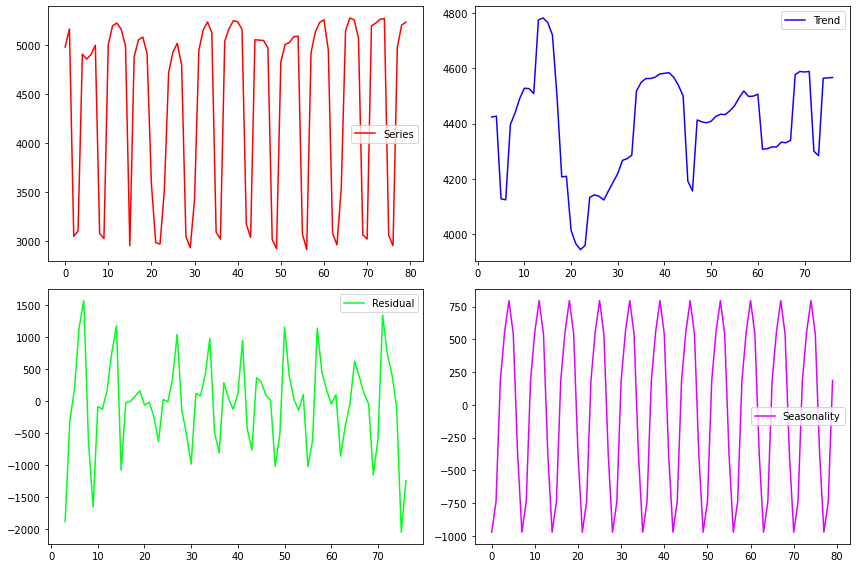

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose

daux = dataset[:80]
decomposition=seasonal_decompose(daux, model='additive', period=7)
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.plot(daux,color='#ff0000', label='Series')
plt.legend(loc='best')
plt.subplot(222)
plt.plot(trend,color='#1100ff', label='Trend')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(223)
plt.plot(residual,color='#00ff1a', label='Residual')
plt.legend(loc='best')
plt.tight_layout()
plt.subplot(224)
plt.plot(seasonal,color='#de00ff', label='Seasonality')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

Graficamos los kilowatts consumidos por día...

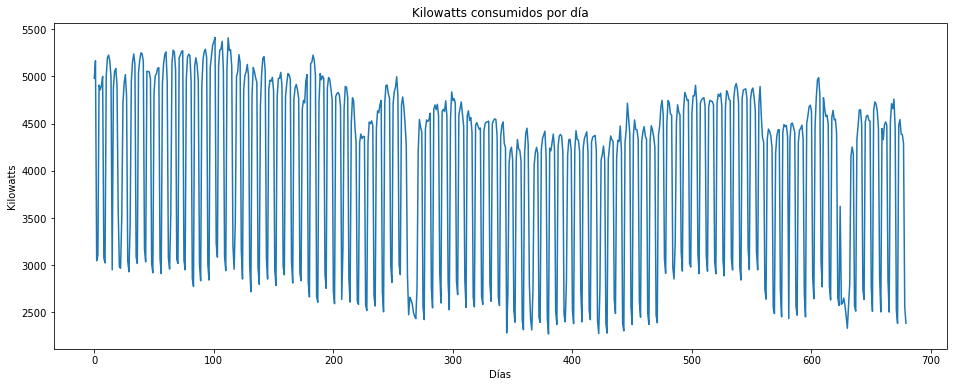

In [39]:
plt.figure(figsize=(16, 6))
plt.plot(dataset)
plt.xlabel('Días')
plt.ylabel('Kilowatts')
plt.title("Kilowatts consumidos por día")
plt.show()

## 5. Entrenar el modelo

* En este laboratorio veremos dos formas implementar un modelo de predicción para una serie de tiempo: **ARIMA** y **LSTM**. 
* El **objetivo** es poder comparar ambas técnicas y conocer sus implementaciones.
* Se prepara un 80% de los datos para entrenamiento y 20% de los datos para pruebas.


In [41]:
# 80% de los datos para entrenamiento
train_df=dataset[:554]
print(train_df.shape)
# 20% de los datos para pruebas
test_df=dataset[554:693]
print(test_df.shape)


(554,)
(126,)


### 5.1 ARIMA

Se utiliza un modelo **ARIMA** (_Autoregressive Integrated Moving Average_) para tomar los componentes de la serie de tiempo en cuestión (es decir, los parámetros **p**, **d** y **q**) y hacer nuevos pronósticos.

Si bien pmdarima se utilizará para seleccionar estas coordenadas automáticamente, es importante definir la tendencia estacional.

El primer 80% de las series de tiempo (544 observaciones) se utilizan como datos de entrenamiento.

#### Autocorrelación (I)

Graficamos la función de autocorrelación generada por el conjunto de entrenamiento.

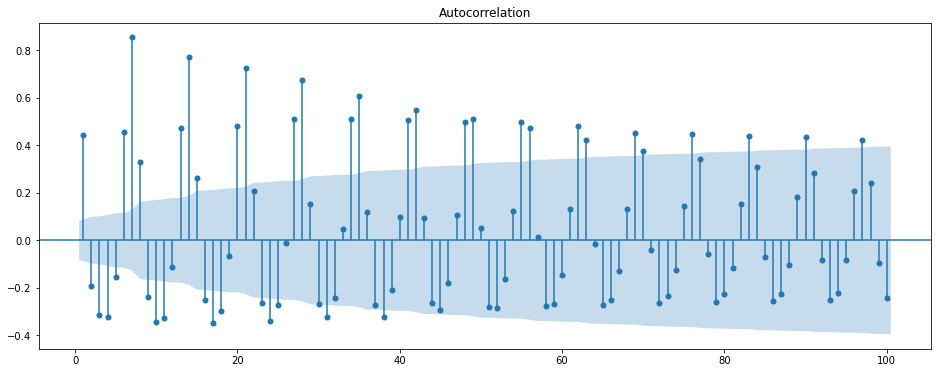

In [42]:
import matplotlib as mpl

with mpl.rc_context():
    mpl.rc("figure", figsize=(16,6))
    plot_acf(train_df, lags=100, zero=False)

 Con 10 días... (Autocorrelación parcial)

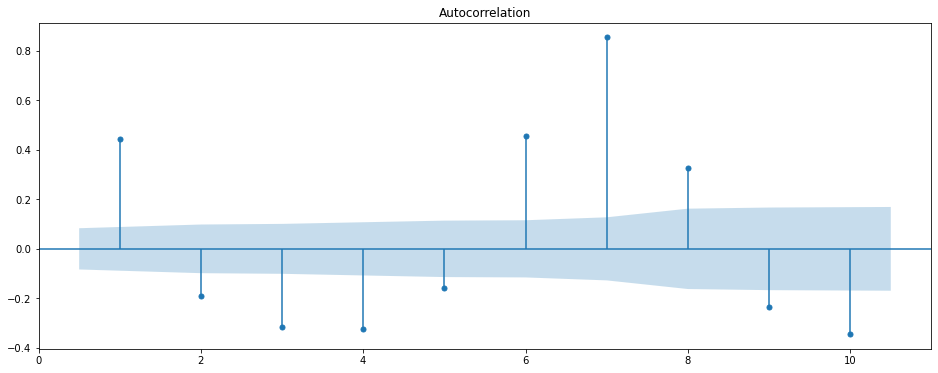

In [12]:
import matplotlib as mpl

with mpl.rc_context():
    mpl.rc("figure", figsize=(16,6))
    plot_acf(train_df, lags=10, zero=False)

Con 10 días... (Autocorrelación)

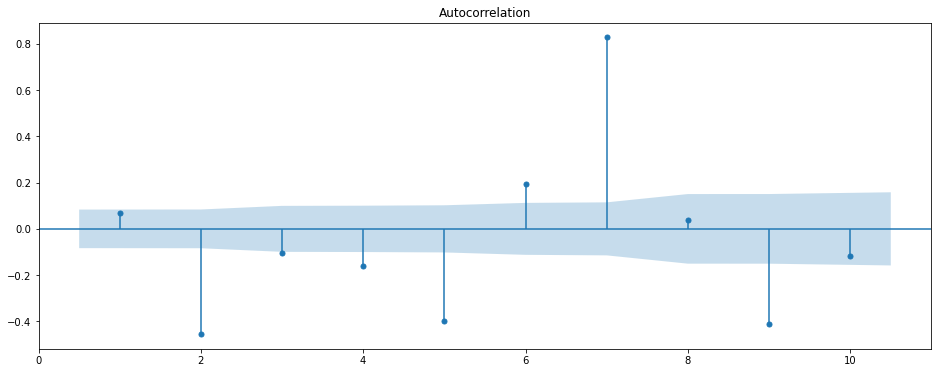

In [13]:
import matplotlib as mpl

with mpl.rc_context():
    mpl.rc("figure", figsize=(16,6))
    plot_acf(np.diff(train_df, 1), lags=10, zero=False)

#### Autocorrelación (II)

* Podemos ver que la correlación positiva más alta (después de las correlaciones negativas) se identifica en el rezago **7**. Esto indica que existe una fuerte correlación con la lectura de kilovatios 7 días después del original.
* En este sentido, el componente estacional para el modelo ARIMA se identifica como **m = 7**.


#### Media móvil (I)

Antes de ejecutar el modelo ARIMA, echemos un vistazo rápido al promedio móvil de **7 días** para esta serie de tiempo, a fin de visualizar mejor la tendencia general.

In [44]:
window_size = 7

numbers_series = pd.Series(train_df)
windows = numbers_series.rolling(window_size)
moving_averages = windows.mean()

moving_averages_list = moving_averages.tolist()
ts7 = moving_averages_list[window_size - 1:]
ts7=np.array(ts7)

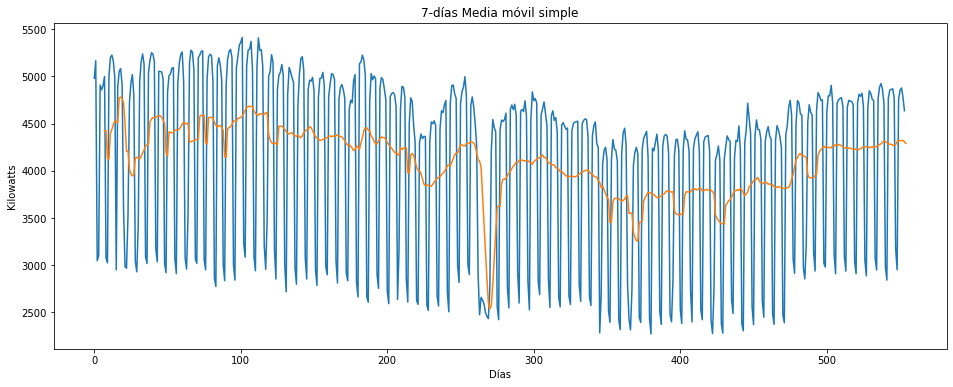

In [45]:
n1=math.nan
n7=np.array([n1,n1,n1,n1,n1,n1,n1])
ts7=np.concatenate([n7,ts7])
plt.figure(figsize=(16,  6))
plt.plot(train_df)
plt.plot(ts7)
plt.xlabel('Días')
plt.ylabel('Kilowatts')
plt.title("7-días Media móvil simple")
plt.show()

#### Media móvil (II)

* En el cálculo de la media móvil podemos ver que en la primera mitad de la serie el consume disminuye y que en la segunda midad comienza a incrementar.
* En la serie de tiempo se ve una fuerte caída en el consumo (mitad de la serie), lo que claramente muestra una anomalía.
* Podemos inferir que en el punto de anomalía pudo ocurrir un evento que no se repite habitualmente, a esto se le llama _shock_ de serie temporal. En este caso, este _shock_ podría ser una caída general del consumo eléctrico.

### 5.2 Entrenamiento del modelo con ARIMA

Usando los datos de entrenamiento, ahora se realiza una búsqueda paso a paso usando pmdarima para minimizar el valor de AIC, es decir, seleccione el modelo ARIMA que muestra el AIC más bajo.

In [46]:
Arima_model=pm.auto_arima(train_df, start_p=0, start_q=0, max_p=10, max_q=10, 
                          start_P=0, start_Q=0, max_P=10, max_Q=10, m=7, stepwise=True, 
                          seasonal=True, information_criterion='aic', trace=True, d=1, D=1, 
                          error_action='warn', suppress_warnings=True, random_state = 20, n_fits=30)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=8483.714, Time=0.63 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=8421.989, Time=0.17 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=8319.248, Time=0.38 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=8360.091, Time=0.09 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=8328.690, Time=0.25 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=1.14 sec
 ARIMA(0,1,0)(0,1,1)[7]             : AIC=8451.400, Time=0.12 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=inf, Time=0.51 sec
 ARIMA(0,1,2)(0,1,1)[7]             : AIC=inf, Time=0.43 sec
 ARIMA(1,1,0)(0,1,1)[7]             : AIC=8415.537, Time=0.07 sec
 ARIMA(1,1,2)(0,1,1)[7]             : AIC=inf, Time=0.65 sec
 ARIMA(0,1,1)(0,1,1)[7] intercept   : AIC=8321.247, Time=0.69 sec

Best model:  ARIMA(0,1,1)(0,1,1)[7]          
Total fit time: 

#### Resultados

* El modelo ARIMA más adecuado se identifica como ARIMA (0,1,1) (0,1,1) [7]
* Ahora, se puede hacer una predicción para los próximos 126 días, comparando las predicciones con los resultados reales obtenidos en todo el conjunto de pruebas.

In [17]:
prediction=pd.DataFrame(Arima_model.predict(n_periods=126), index=test_df)
prediction=np.array(prediction)
print(prediction[:4, :])

[[3107.73902753]
 [2911.60627771]
 [4743.5931294 ]
 [4842.81281425]]


Calculamos el error cuadrático medio...

In [18]:
mse = mean_squared_error(test_df, prediction)
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 1288.000496


In [19]:
consumo_medio = np.mean(test_df)
print(f'Consumo medio conjunto de pruebas: {consumo_medio}')

Consumo medio conjunto de pruebas: 3862.4563492063494


#### Resultados

El **consumo medio de kilovatios en el conjunto de prueba fue de 3.862**. Dado que el error **RMSE representa el 33% del tamaño de la media**, esto indica que el modelo **ARIMA podría estar haciendo un mejor trabajo al pronosticar el consumo de electricidad**.

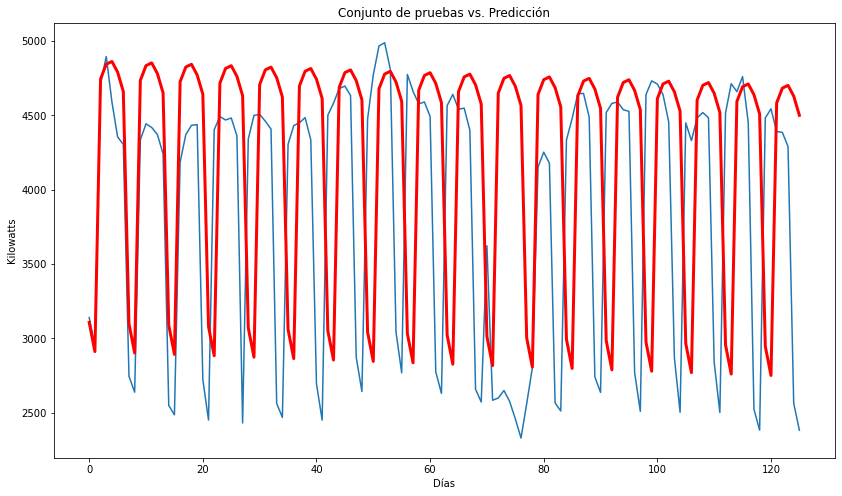

In [20]:
plt.figure(figsize=(14, 8))
plt.plot(test_df)
plt.plot(prediction, c='r', label='y1',linewidth=3.0)
plt.xlabel('Días')
plt.ylabel('Kilowatts')
plt.title("Conjunto de pruebas vs. Predicción")
plt.show()

### 5.2  LSTM

Ahora implementaremos un **modelo LSTM** con el mismo conjunto de datos para examinar si la precisión del pronóstico mejora cuando se usa este enfoque.

Los datos se manipularon inicialmente de la misma manera que antes, es decir, se formó una serie de tiempo diaria agregando el consumo de kilovatios cada 15 minutos en el espacio de un día.

In [24]:
print(train_df.shape)

(554,)


In [70]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

# Normalizo los datos
sc = MinMaxScaler()
training_data = sc.fit_transform(dataset.reshape(-1,1))


# Ventana de 7 valores
seq_length = 7
x, y = sliding_windows(training_data, seq_length)

# 80% de los datos para entrenamiento
train_size = 554
# 20% de los datos para pruebas
test_size = 680

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:test_size])))
testY = Variable(torch.Tensor(np.array(y[train_size:test_size])))

#### Construir modelo LSTM

In [33]:

class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

#### Entrenamiento

In [81]:
num_epochs = 2000
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    if epoch % 100 == 0:
      print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.08917
Epoch: 100, loss: 0.05297
Epoch: 200, loss: 0.01910
Epoch: 300, loss: 0.01521
Epoch: 400, loss: 0.01364
Epoch: 500, loss: 0.01351
Epoch: 600, loss: 0.01303
Epoch: 700, loss: 0.01288
Epoch: 800, loss: 0.01281
Epoch: 900, loss: 0.01310
Epoch: 1000, loss: 0.01252
Epoch: 1100, loss: 0.01241
Epoch: 1200, loss: 0.01229
Epoch: 1300, loss: 0.01218
Epoch: 1400, loss: 0.01241
Epoch: 1500, loss: 0.01191
Epoch: 1600, loss: 0.01179
Epoch: 1700, loss: 0.01168
Epoch: 1800, loss: 0.01170
Epoch: 1900, loss: 0.01148


## 6. Evaluar modelo

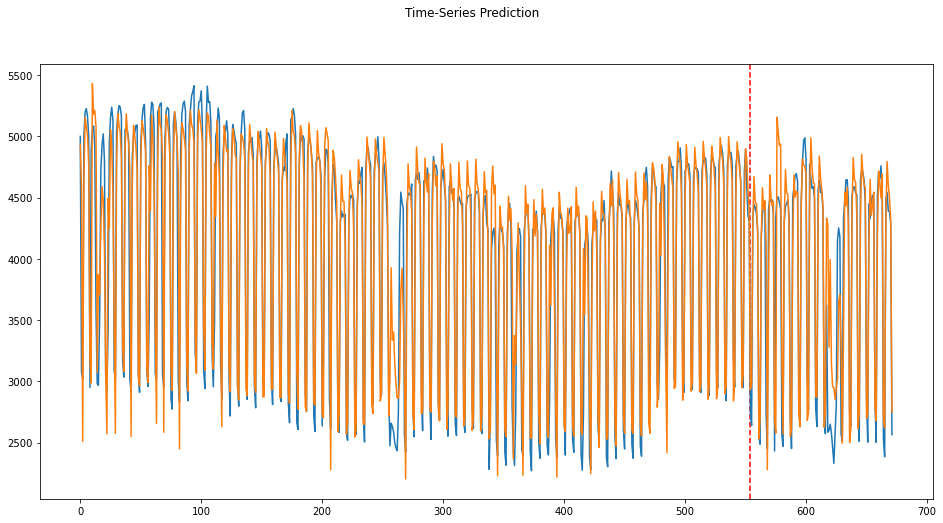

In [82]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(16, 8))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

In [83]:
lstm.eval()
test_predict = lstm(testX)

#print(np.array(training_data[train_size:test_size]))
#print(test_predict.detach().numpy())
mse = mean_squared_error(np.array(training_data[train_size+8:test_size]), test_predict.detach().numpy())
rmse = math.sqrt(mse)
print('RMSE: %f' % rmse)


RMSE: 0.327896
